**YOUR NAMES HERE**

Spring 2025

CS 444: Deep Learning

Project 1: Deep Neural Networks 

#### Week 3: Strategies for training deeper networks

The focus this week is on strategies for training deeper neural networks. We will touch on:
1. Improved weight initialization techniques.
2. Using dropout.
3. Using regularization.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

### 6c. Add support for He/Kaiming initialization

Continuing on with our goal of improving our training workflow, let's implement He/Kaiming initialization weight initialization in layers that contain weights (`'he'` method). We want to maintain support for the current way weights are initialized (`'normal'` method) so that we can switch between the method used to initialize the weights. In summary, the process involves a) adding support for `'he'` weight initialization in layers with weights and b) adding keyword arguments to allow switching between the weight initialization methods.

Here are the changes to make:
1. In `Layer`, implement `get_kaiming_gain` to get the activation function dependent Kaiming gain $\kappa$.
2. If you have not already done so, add instance vars for the  `wt_init` parameter in:
   1. `Dense` constructor
   2. `Conv2D` constructor
   3. `VGG4` constructor
   4. `VGGConvBlock` constructor
   5. `VGGDenseBlock` constructor
   6. `VGG6` constructor
3. In the following places, initialize the weights and bias in the way you are currently are if using the `'normal'` the weight initialization method (*the default in all layers so far*). Otherwise, use He/Kaiming:
   1. `Dense` `init_params`
   2. `Conv2D` `init_params`
4. Make sure you are passing the `wt_init` parameter setting along when making layers/blocks in the following places:
   1. `VGGConvBlock`
   2. `VGGDenseBlock`
   3. `VGG4`
   4. `VGG6`

In [13]:
from layers import Dense, Conv2D
from block import VGGConvBlock, VGGDenseBlock
from vgg_nets import VGG4, VGG6

#### Test `Dense`

Also re-run previous tests in the `build_deeplib` notebook to make sure adding support for He/Kaiming initialization does not affect `'normal'` initialzation.

In [18]:
tf.random.set_seed(0)
d = Dense('Test', units=3, wt_init='he')
d(tf.ones([2, 4]))
print(f'Your wts are\n{d.get_wts().numpy()} and should be')
print('''[[ 1.068  0.299 -0.297]
 [-0.733 -0.875  0.333]
 [-0.01   0.841  0.426]
 [ 0.424 -0.499 -0.306]]''')
print(f'Your biases are\n{d.get_b().numpy()} and should be')
print('[0. 0. 0.]')

Your wts are
[[ 1.068  0.299 -0.297]
 [-0.733 -0.875  0.333]
 [-0.01   0.841  0.426]
 [ 0.424 -0.499 -0.306]] and should be
[[ 1.068  0.299 -0.297]
 [-0.733 -0.875  0.333]
 [-0.01   0.841  0.426]
 [ 0.424 -0.499 -0.306]]
Your biases are
[0. 0. 0.] and should be
[0. 0. 0.]


#### Test `Conv2D`

Also re-run previous tests in the `build_deeplib` notebook to make sure adding support for He/Kaiming initialization does not affect `'normal'` initialzation.

In [21]:
tf.random.set_seed(0)
c = Conv2D('Test', units=3, wt_init='he', kernel_size=(2,2))
c(tf.ones([1, 6, 6, 2]))
print(f'Your wts are\n{c.get_wts().numpy()} and should be')
print('''[[[[ 0.756  0.211 -0.21 ]
   [-0.518 -0.618  0.235]]

  [[-0.007  0.594  0.301]
   [ 0.3   -0.353 -0.216]]]


 [[[ 0.397 -0.349 -0.48 ]
   [-0.45  -0.18  -0.112]]

  [[ 0.152  0.261  0.078]
   [ 0.794 -0.398  0.039]]]]''')
print(f'Your biases are\n{c.get_b().numpy()} and should be')
print('[0. 0. 0.]')

Your wts are
[[[[ 0.756  0.211 -0.21 ]
   [-0.518 -0.618  0.235]]

  [[-0.007  0.594  0.301]
   [ 0.3   -0.353 -0.216]]]


 [[[ 0.397 -0.349 -0.48 ]
   [-0.45  -0.18  -0.112]]

  [[ 0.152  0.261  0.078]
   [ 0.794 -0.398  0.039]]]] and should be
[[[[ 0.756  0.211 -0.21 ]
   [-0.518 -0.618  0.235]]

  [[-0.007  0.594  0.301]
   [ 0.3   -0.353 -0.216]]]


 [[[ 0.397 -0.349 -0.48 ]
   [-0.45  -0.18  -0.112]]

  [[ 0.152  0.261  0.078]
   [ 0.794 -0.398  0.039]]]]
Your biases are
[0. 0. 0.] and should be
[0. 0. 0.]


#### Test `VGGConvBlock`

In [22]:
tf.random.set_seed(0)
v = VGGConvBlock('Test', units=3, wt_init='he', prev_layer_or_block=None)
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([1, 6, 6, 2]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[[[0.539 0.798 0.174]
   [1.075 0.599 0.   ]
   [0.713 0.7   0.   ]]

  [[0.497 1.139 0.191]
   [0.826 1.057 0.075]
   [0.506 1.095 0.   ]]

  [[0.358 0.638 0.168]
   [0.547 0.29  0.189]
   [0.726 0.337 0.111]]]]''')

Your net_acts are
[[[[0.539 0.798 0.174]
   [1.075 0.599 0.   ]
   [0.713 0.7   0.   ]]

  [[0.497 1.139 0.191]
   [0.826 1.057 0.075]
   [0.506 1.095 0.   ]]

  [[0.358 0.638 0.168]
   [0.547 0.29  0.189]
   [0.726 0.337 0.111]]]] and should be
[[[[0.539 0.798 0.174]
   [1.075 0.599 0.   ]
   [0.713 0.7   0.   ]]

  [[0.497 1.139 0.191]
   [0.826 1.057 0.075]
   [0.506 1.095 0.   ]]

  [[0.358 0.638 0.168]
   [0.547 0.29  0.189]
   [0.726 0.337 0.111]]]]


#### Test `VGGDenseBlock`

In [23]:
tf.random.set_seed(0)
v = VGGDenseBlock('Test', units=(3,), wt_init='he', prev_layer_or_block=None)
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([1, 4]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.565 0.    0.   ]] ''')

Your net_acts are
[[0.565 0.    0.   ]] and should be
[[0.565 0.    0.   ]] 


#### Test `VGG4`

In [24]:
tf.random.set_seed(0)
v = VGG4(C=3, input_feats_shape=(10, 10, 5), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([2, 10, 10, 5]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.369 0.382 0.249]
 [0.37  0.351 0.28 ]]''')

Your net_acts are
[[0.369 0.382 0.249]
 [0.37  0.351 0.28 ]] and should be
[[0.369 0.382 0.249]
 [0.37  0.351 0.28 ]]


#### Test `VGG6`

In [25]:
tf.random.set_seed(0)
v = VGG4(C=4, input_feats_shape=(12, 12, 4), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([1, 12, 12, 4]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.228 0.107 0.589 0.075]]''')

Your net_acts are
[[0.228 0.107 0.589 0.075]] and should be
[[0.228 0.107 0.589 0.075]]


### 6d. Compare training VGG6 with Normal and He initialization with early stopping

Let's use VGG6 to test how He initialization and early stopping affects training with CIFAR-10. In the cell below, conduct an experiment wherein you train VGG6 repeatedly 6 times will different combinations of the following: 
- patience `[3, 4, 5]`
- Normal vs He

After training each net, store/record:
1. the network's final test accuracy.
2. the number of epochs spent training.
3. the history of training loss (averaged across mini-batches, so one per epoch).
4. the history of validation loss (checked every epoch).
5. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the networks to help prevent the memory used from growing.
- Some networks may stop very quickly — that is ok and expected!

This experiment is expected to take 30-60 mins to complete.

In [31]:
# Load CIFAR-10
from datasets import get_dataset
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset("cifar10")

# Configurations
patience_values = [3, 4, 5]
init_types = ["normal", "he"]

# Storage dictionaries
training_losses = {}
val_losses = {}
val_accs = {}
test_accs = {}
epochs = {}


# Train models with different configurations
for init in init_types:
    for patience in patience_values:
        tf.random.set_seed(0)
        tf.keras.backend.clear_session()
        print(f"Training VGG6 with {init} initialization and patience={patience}")

        model = VGG6(10, (32, 32, 3), wt_init=init)
        model.compile()
        train_loss_hist, val_loss_hist, val_acc_hist, num_epochs = model.fit(x_train, y_train, x_val, y_val, max_epochs=1000, patience=patience)

        key = f"{init}{patience}"
        training_losses[key] = train_loss_hist
        val_losses[key] = val_loss_hist
        val_accs[key] = val_acc_hist
        test_accs[key] = model.evaluate(x_test, y_test)[0]
        epochs[key] = num_epochs


Training VGG6 with normal initialization and patience=3
---------------------------------------------------------------------------
Dense layer output(output_layer) shape: [1, 10]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 256]
	Dense layer output(DenseBlock1/dense_0) shape: [1, 256]
Flatten layer output(flat) shape: [1, 8192]
ConvBlock2:
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 8, 8, 128]
	Conv2D layer output(ConvBlock2/conv_1) shape: [1, 16, 16, 128]
	Conv2D layer output(ConvBlock2/conv_0) shape: [1, 16, 16, 128]
ConvBlock1:
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 16, 16, 64]
	Conv2D layer output(ConvBlock1/conv_1) shape: [1, 32, 32, 64]
	Conv2D layer output(ConvBlock1/conv_0) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
Epoch 1: Training Loss = 2.1215, Validation Loss = 1.7783, Validation Accuracy = 0.3265
Epoch 1/1000 took 18.0552 seconds
Epoch 2: Training Loss = 1.6376, Val

Use the function below to plot:
1. The training loss history.
2. The val loss history.
3. The val acc history.

Afterwards print the test accuracy for each network along wth the number of actual training epochs.

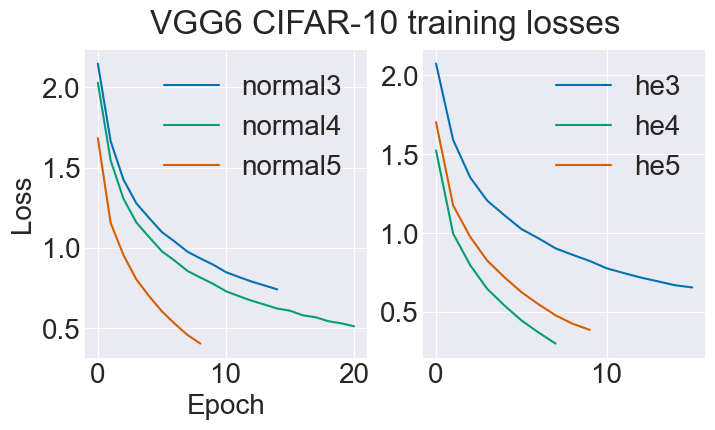

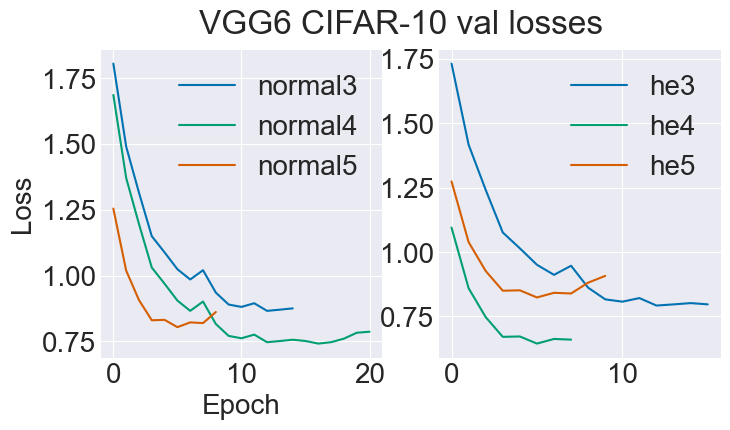

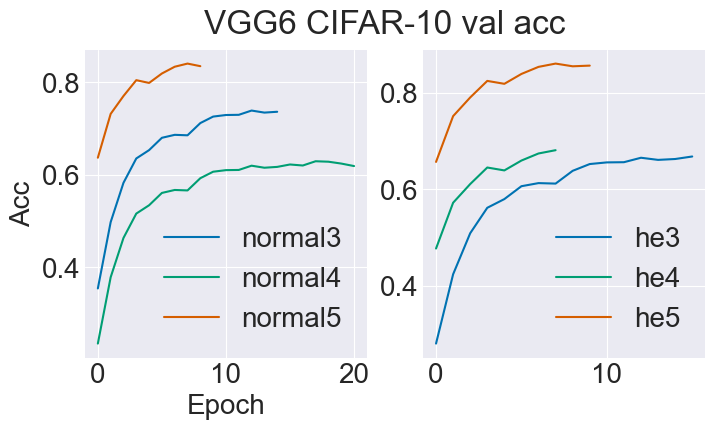

Test accs:
normal3: 69.51 in 15 epochs.
normal4: 69.74 in 16 epochs.
normal5: 69.56 in 21 epochs.
he3: 75.75 in 8 epochs.
he4: 75.56 in 9 epochs.
he5: 75.73 in 10 epochs.


In [32]:
def plot_loss_and_acc_wt_init_exp(hists,
                                  labels=['normal3', 'he3', 'normal4', 'he4', 'normal5', 'he5'],
                                  title='',
                                  ylabel=''):
    '''Plots either the training loss history, val loss history, or val acc history for the 6 networks.

    This plotting function is provided to you. Feel free to modify to suit your needs.

    Parameters:
    -----------
    hists: list of lists. len(hists)=6. len(sublists) = E, where E is number of epochs used to train.
        The training loss, val loss, OR val acc history for the 6 networks.
    labels: list of str.
        The labels/order of conditions in the hists. Modify if your order does not match the default.
    title: str.
        A useful title.
    ylabel: str.
        A useful y label.
    '''
    if len(hists) != len(labels):
        print('The length of the hists needs to match the labels length — one label per history')
        return

    rng = np.random.default_rng(0)
    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

    for i in range(len(labels)):
        hist = hists[i]
        label = labels[i]
        shift = rng.uniform(low=-0.1, high=0.1, size=(1,))
        if 'normal' in label:
            axes[0].plot(hist+shift, label=label)
        else:
            axes[1].plot(hist+shift, label=label)

    axes[0].legend()
    axes[1].legend()
    fig.suptitle(title)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel(ylabel)
    plt.show()

# This code is here to help you plot your results and test accuracies. It will almost certainly not exactly work
# with your variables. Feel free to adapt to suit your needs or delete and use your own code.
plot_loss_and_acc_wt_init_exp(list(training_losses.values()),
                              title='VGG6 CIFAR-10 training losses', ylabel='Loss')
plot_loss_and_acc_wt_init_exp(list(val_losses.values()),
                              title='VGG6 CIFAR-10 val losses', ylabel='Loss')
plot_loss_and_acc_wt_init_exp(list(val_accs.values()),
                              title='VGG6 CIFAR-10 val acc', ylabel='Acc')

print('Test accs:')
for label, acc in test_accs.items():
    print(f'{label}: {100*acc:.2f} in {epochs[label]} epochs.')

### 6e. Questions

**Question 5:** How did the networks initialized with the Normal method compare to those initialized with He?

**Question 6:** How does the test accuracy achieved by the best performing VGG6 network compare to:
- the previous best VGG6 result you obtained (before this Task)?
- the best VGG4 result?

**Answer 5:**
The networks initialized with the He method outperformed those initialized with the Normal method. Specifically, the He-initialized networks achieved ~75.7% accuracy in significantly fewer epochs (8–10), indicating faster convergence. The Normal-initialized networks reached ~69.5% accuracy and took longer to converge (15–21 epochs).

**Answer 6:**
The test accuracy achieved by the best performing VGG6 network initialized with He improved in both accuracy and convergence speed over the previous best VGG6 and VGG4 result.

## Task 7: Going deeper with VGG8

With deeper networks, overfitting becomes a major concern. In this task, we will explore two ways to regularize deep neural networks and analyze the impact they have on classification accuracy.

### 7a. Implement VGG8

In `vgg_nets.py` implement the `VGG8` class. The VGG8 network has the following architecture:

Conv2D → Conv2D → MaxPool2D → Conv2D → Conv2D → MaxPool2D → Conv2D → Conv2D → MaxPool2D → Flatten → Dense → Dropout → Dense

If you copy-paste from VGG6, this should be fast.

In [ ]:
from vgg_nets import VGG8

#### Test `VGG8`

In [ ]:
v = VGG8(C=5, input_feats_shape=(24, 24, 10), wt_init='he')
v.compile()

The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 5]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 2304]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 3, 3, 256]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 6, 6, 256]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 6, 6, 256]
ConvBlock2:
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 6, 6, 128]
	Conv2D layer output(ConvBlock2/conv1) shape: [1, 12, 12, 128]
	Conv2D layer output(ConvBlock2/conv0) shape: [1, 12, 12, 128]
ConvBlock1:
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 12, 12, 64]
	Conv2D layer output(ConvBlock1/conv1) shape: [1, 24, 24, 64]
	Conv2D layer output(ConvBlock1/conv0) shape: [1, 24, 24, 64]
---------------------------------------------------------------------------
```


In [ ]:
tf.random.set_seed(0)
v = VGG8(C=5, input_feats_shape=(12, 12, 10), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([1, 12, 12, 10]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.132 0.207 0.576 0.025 0.06 ]]''')

### 7b. Effects of dropout

In the cell below, train VGG8 with and without dropout in the convolutional blocks (i.e. train 2 separate nets). Train with a patience of `4` and use He initialization.

After training each net, store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).
4. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the network to help prevent the memory used from growing.

Use the function below to plot:
1. The training loss history.
2. The val loss history.
3. The val acc history.

Afterwards print the test accuracy for each network along wth the number of actual training epochs.

In [ ]:
def plot_hist_dropout_exp(hist_nodropout, hist_dropout, title, ylabel):
    '''Plots either the training loss history, val loss history, or val acc history for the net trained with and
    without dropout.

    This plotting function is provided to you. Feel free to modify to suit your needs.

    Parameters:
    -----------
    hist_nodropout: array-like. len(hist_nodropout)=E, where E is number of epochs used to train.
        The training loss, val loss, OR val acc history for the net trained without dropout.
    hist_dropout: array-like. len(hist_dropout)=E, where E is number of epochs used to train.
        The training loss, val loss, OR val acc history for the net trained with dropout.
    title: str.
        A useful title.
    ylabel: str.
        A useful y label.
    '''
    plt.plot(hist_nodropout, label='No dropout')
    plt.plot(hist_dropout, label='Dropout')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.show()



### 7c. Questions

**Question 7:** What effect does the dropout have on the training and validation loss? What accounts the difference you observe? Please be specific.

**Question 8:** What effect does the dropout have on the CIFAR10 test accuracy you achieved?

**Question 9:** How does the test accuracy achieved with VGG8 (with and without dropout) compare to the best performing VGG6 network?

**Answer 7:**

**Answer 8:**

**Answer 9:**

### 7d. Add support for AdamW optimizer

Another way to combat overfitting is more "traditional" regularization. But Adam may no longer be best choice when introducing this into training.

In the `compile` method of `DeepNetwork`, add support for the AdamW optimizer (suggested string to select: `'adamw'`). When you create the AdamW optimizer object, specify the learning rate AND set the `weight_decay` keyword argument to the network's regularization strength. Since we are using the Keras built-in optimizer, this should be a one-liner.

### 7e. Regularization and choice of optimizer

In the cell below, train VGG8 repeatedly with the following combinations of optimizer and regularization choices (*4 nets trained total*):

**(Reg strength, optimizer):** `(0.6, Adam), (0.6, AdamW), (0.06, Adam), (0.0, Adam)`

Do **not** use dropout in the conv blocks. Train with a patience of `4`. Use He initialization.

After training each net, store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).
4. the history of validation accuracy (checked every epoch).

**Notes:**
- Set random seed before creating each net for consistency.
- Use `tf.keras.backend.clear_session()` before creating each of the network to help prevent the memory used from growing.

In [ ]:
def plot_hist_optimizer_exp(adamw_hist, adam_hists, adam_labels=['adam_reg', 'adam_low_reg', 'adam_no_reg'],
                            title='',
                            ylabel=''):
    '''Plots either the training loss history, val loss history, or val acc history for the nets trained with adam and
    adamw.

    This plotting function is provided to you. Feel free to modify to suit your needs.

    Parameters:
    -----------
    adamw_hist: array-like. len(hist_nodropout)=E, where E is number of epochs used to train.
        The training loss, val loss, OR val acc history for the net trained with Adam.
    adam_hists: list of lists. len(hists)=3. len(sublists) = E, where E is number of epochs used to train.
        The training loss, val loss, OR val acc history for the 3 networks.
    labels: list of str.
        The labels/order of conditions in adam_hists. Modify if your order does not match the default.
    title: str.
        A useful title.
    ylabel: str.
        A useful y label.
    '''
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))

    axes[0].plot(adamw_hist, label='adamw_reg')
    for i in range(len(adam_labels)):
        axes[1].plot(adam_hists[i], label=adam_labels[i])

    axes[0].legend()
    axes[1].legend()
    fig.suptitle(title)
    axes[0].set_ylabel(ylabel)
    axes[1].set_xlabel('Epoch')
    plt.show()

# This code is here to help you plot your results and test accuracies. It will almost certainly not exactly work
# with your variables. Feel free to adapt to suit your needs or delete and use your own code.
plot_hist_optimizer_exp(train_losses[0], train_losses[1:], title='VGG8 CIFAR-10 training losses', ylabel='Loss')
plot_hist_optimizer_exp(val_losses[0], val_losses[1:], title='VGG8 CIFAR-10 val losses', ylabel='Loss')
plot_hist_optimizer_exp(val_accs[0], val_accs[1:], title='VGG8 CIFAR-10 val accs', ylabel='Accuracy')


all_labels = ['adamw_reg', 'adam_reg', 'adam_low_reg', 'adam_no_reg']
print('Test accs:')
print()
for i in range(len(all_labels)):
    print(f'{all_labels[i]}: {100*test_accs[i]:.2f}')

### 7c. Questions

**Question 10:** What effect does regularization have with Adam? When does it perform best/worst? How do you know?

**Question 11:** How does the results with AdamW compare with the nets trained with Adam?

**Answer 10:**

**Answer 11:**

## Task 8: Going even deeper with VGG15

This network is an approximation of the VGG19 network from the VGG paper. This is a big and deep model:
- 5 conv blocks. First two blocks have 2 conv layers, each. The remaining blocks have 3 conv layers each. There is no dropout in any of the conv blocks.
- flatten layer.
- 1 dense block with dropout.
- 1 dense output layer with softmax activation.

In this task, the goal is to implement VGG15 and assess its baseline accuracy on CIFAR-10.

### 8a. Implement and test VGG15

If you copy-paste from VGG8, this should be fast.

In [ ]:
from vgg_nets import VGG15

#### Test: `VGG15`

In [ ]:
v = VGG15(C=5, input_feats_shape=(32, 32, 3), wt_init='he')
v.compile()

The above should print:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 5]
DenseBlock1:
	Dropout layer output(DenseBlock1/dropout) shape: [1, 512]
	Dense layer output(DenseBlock1/dense0) shape: [1, 512]
Flatten layer output(flat) shape: [1, 512]
ConvBlock5:
	MaxPool2D layer output(ConvBlock5/maxpool2) shape: [1, 1, 1, 512]
	Conv2D layer output(ConvBlock5/conv2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv1) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock5/conv0) shape: [1, 2, 2, 512]
ConvBlock4:
	MaxPool2D layer output(ConvBlock4/maxpool2) shape: [1, 2, 2, 512]
	Conv2D layer output(ConvBlock4/conv2) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv1) shape: [1, 4, 4, 512]
	Conv2D layer output(ConvBlock4/conv0) shape: [1, 4, 4, 512]
ConvBlock3:
	MaxPool2D layer output(ConvBlock3/maxpool2) shape: [1, 4, 4, 256]
	Conv2D layer output(ConvBlock3/conv2) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv1) shape: [1, 8, 8, 256]
	Conv2D layer output(ConvBlock3/conv0) shape: [1, 8, 8, 256]
ConvBlock2:
	MaxPool2D layer output(ConvBlock2/maxpool2) shape: [1, 8, 8, 128]
	Conv2D layer output(ConvBlock2/conv1) shape: [1, 16, 16, 128]
	Conv2D layer output(ConvBlock2/conv0) shape: [1, 16, 16, 128]
ConvBlock1:
	MaxPool2D layer output(ConvBlock1/maxpool2) shape: [1, 16, 16, 64]
	Conv2D layer output(ConvBlock1/conv1) shape: [1, 32, 32, 64]
	Conv2D layer output(ConvBlock1/conv0) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```


In [ ]:
tf.random.set_seed(0)
v = VGG15(C=5, input_feats_shape=(32, 32, 3), wt_init='he')
tf.random.set_seed(1)
net_acts = v(tf.random.uniform([3, 32, 32, 3]))

print(f'Your net_acts are\n{net_acts.numpy()} and should be')
print('''[[0.096 0.298 0.203 0.319 0.084]
 [0.089 0.278 0.216 0.33  0.087]
 [0.087 0.277 0.214 0.345 0.078]]''')

### 8b. Train VGG15 on CIFAR-10

Here is how you should setup training:
1. Train with patience of `4`.
2. Use He initialization.
3. Use AdamW and regularization of `0.6`.

Store/record:
1. the network's final test accuracy.
2. the history of training loss (averaged across mini-batches, so one per epoch).
3. the history of validation loss (checked every epoch).

**Notes:**
- Set random seed at the beginning for consistency.
- Use `tf.keras.backend.clear_session()` at the beginning to help prevent the memory used from growing.

In [ ]:
tf.random.set_seed(0)
tf.keras.backend.clear_session()



In the cell below, plot the VGG15 train and validation loss history over epochs. Place the test acc in the title.

### 8c. Questions

**Question 12:** How does the baseline accuracy of VGG15 compare to the best accuracies you achieved with the shallower networks? Did this surprise you?

**Answer 12:**